Calculated tilt angle: -15.95 degrees


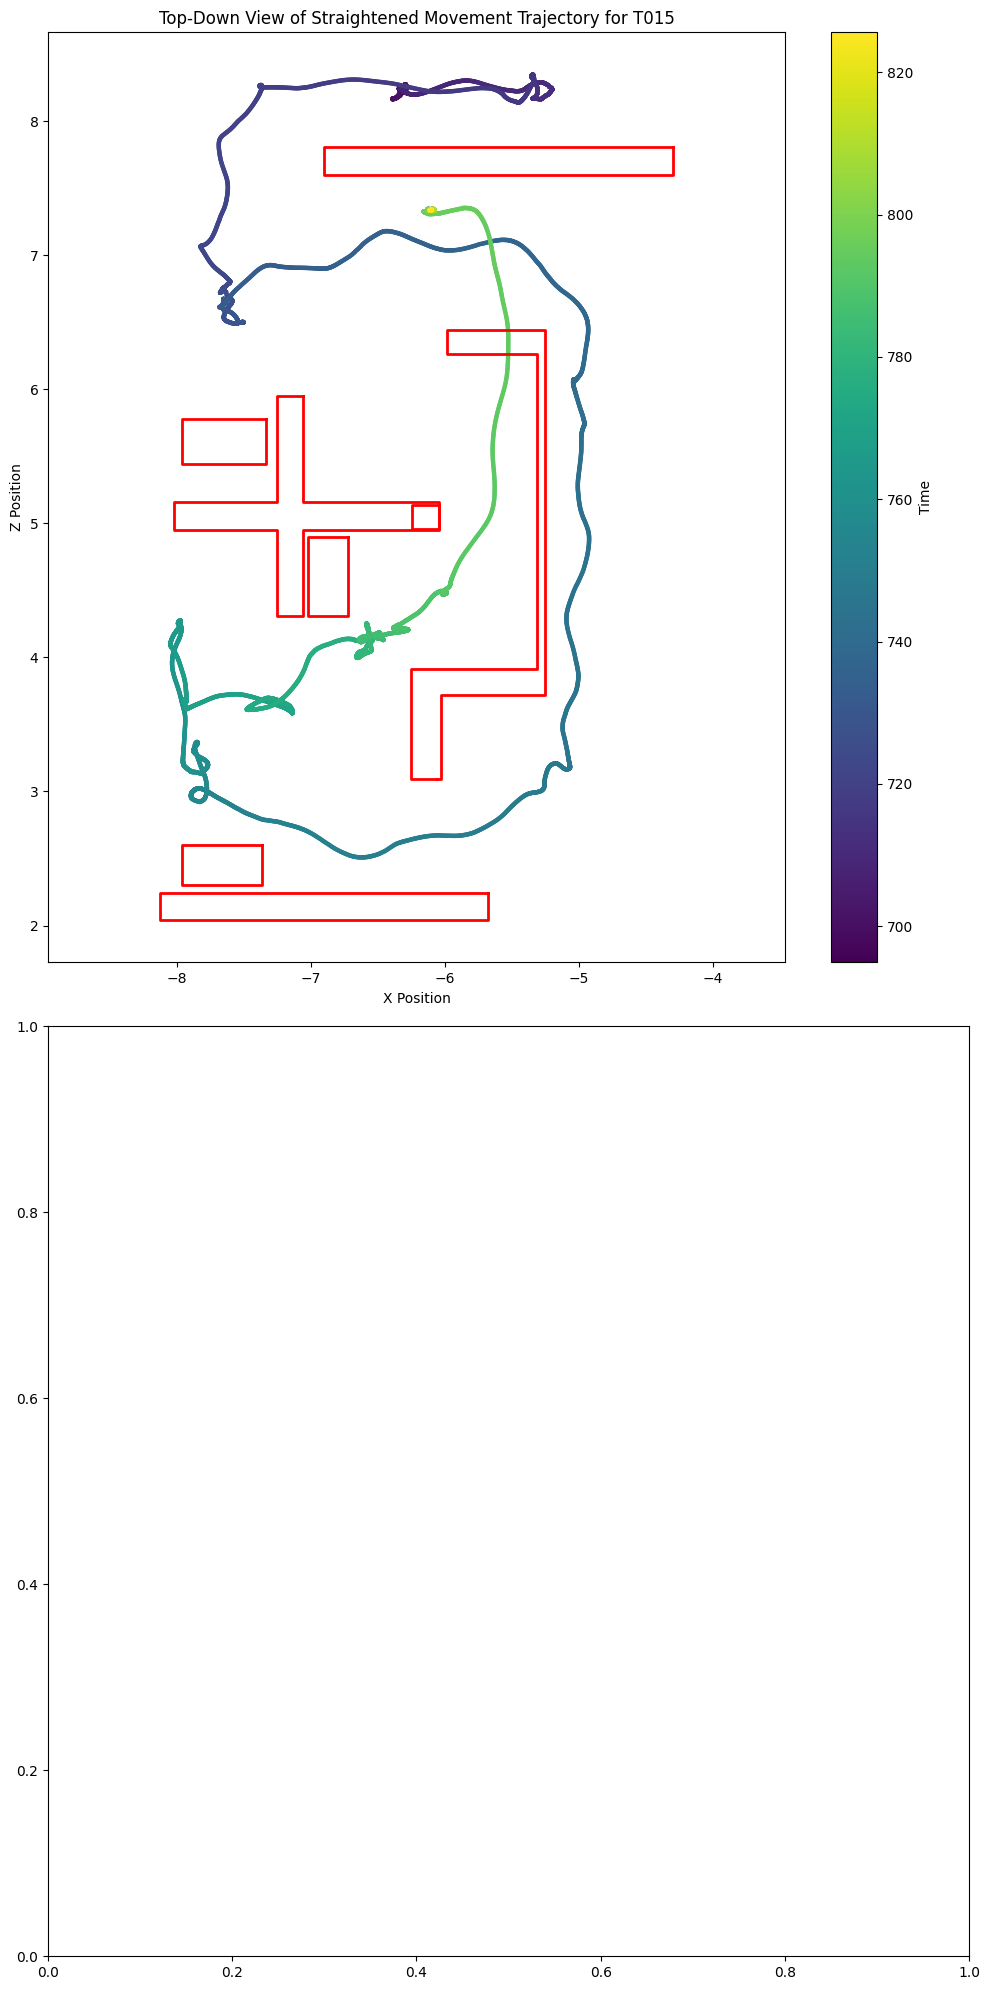

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from shapely.geometry import Polygon, LineString, MultiPolygon, Point
from matplotlib.patches import PathPatch
from matplotlib.path import Path

def calculate_tilt_angle(platform_coords):
    x1, z1 = platform_coords[0]
    x2, z2 = platform_coords[1]
    dx = x2 - x1
    dz = z2 - z1
    slope = dz / dx
    angle = np.arctan(slope)
    angle_deg = np.degrees(angle)
    return np.radians(-angle_deg)

def rotate_points(x, z, angle, center_x, center_z):
    x_centered = x - center_x
    z_centered = z - center_z
    x_rotated = x_centered * np.cos(angle) + z_centered * np.sin(angle)
    z_rotated = -x_centered * np.sin(angle) + z_centered * np.cos(angle)
    x_final = x_rotated + center_x
    z_final = z_rotated + center_z
    return x_final, z_final

def create_path_from_polygon(polygon):
    if polygon.is_empty:
        return None

    vertices = []
    codes = []

    def extract_coords(poly):
        # Exterior ring
        x, y = poly.exterior.coords.xy
        coords = list(zip(x, y))
        vertices.extend(coords)
        codes.extend([Path.MOVETO] + [Path.LINETO]*(len(coords)-2) + [Path.CLOSEPOLY])

        # Interior rings (holes)
        for interior in poly.interiors:
            x, y = interior.coords.xy
            coords = list(zip(x, y))
            vertices.extend(coords)
            codes.extend([Path.MOVETO] + [Path.LINETO]*(len(coords)-2) + [Path.CLOSEPOLY])

    if isinstance(polygon, Polygon):
        extract_coords(polygon)
    elif isinstance(polygon, MultiPolygon):
        for poly in polygon.geoms:
            extract_coords(poly)
    else:
        raise ValueError("Unhandled geometry type: {}".format(type(polygon)))

    return Path(vertices, codes)

def calculate_speed(x1, z1, t1, x2, z2, t2):
    distance = np.sqrt((x2 - x1)**2 + (z2 - z1)**2)
    time_diff = t2 - t1
    if time_diff == 0:
        return 0
    return distance / time_diff

def draw_elevated_platform(ax, angle, center_x, center_z):
    platform_coords = [
        (-4.83, 1.89), (-5.46, 1.71), (-5.74, 2.84), (-6.32, 2.68),
        (-6.81, 4.40), (-7.39, 4.24), (-8.05, 6.47), (-5.11, 7.31),
        (-4.45, 5.06), (-5.03, 4.90), (-4.56, 3.17), (-5.14, 3.01),  
    ]
    inner_platform_coords = [
        (-6.00, 3.26), (-6.49, 4.98), (-7.07, 4.82), (-7.47, 6.15), (-5.43, 6.73), (-5.03, 5.38), (-5.60, 5.23), (-5.13, 3.50)
    ]

    rotated_outer_coords = [(-6.00, 1.73), (-6.60, 1.73), (-6.60, 2.89), (-7.20, 2.89), (-7.20, 4.66), (-7.80, 4.66), (-7.80, 7.00), (-4.80, 7.00), (-4.80, 4.66), (-5.40, 4.66), (-5.40, 2.89), (-6.00, 2.89)]
    rotated_outer_coords.append(rotated_outer_coords[0])  # Close the polygon
    xs, zs = zip(*rotated_outer_coords)
    ax.plot(xs, zs, 'r-', linewidth=2)

    rotated_inner_coords= [(-6.78, 3.31), (-6.78, 5.08), (-7.38, 5.08), (-7.38, 6.58), (-5.22, 6.58), (-5.22, 5.08), (-5.82, 5.08), (-5.82, 3.31)]
    rotated_inner_coords.append(rotated_inner_coords[0])  # Close the polygon
    inner_xs, inner_zs = zip(*rotated_inner_coords)
    ax.plot(inner_xs, inner_zs, 'g-', linewidth=2)  # Use green color for inner platform

    # Create shapely Polygons for outer and inner platforms
    outer_polygon = Polygon(rotated_outer_coords)
    inner_polygon = Polygon(rotated_inner_coords)

    # Compute the area between the outer and inner polygons
    red_area_polygon = outer_polygon.difference(inner_polygon)
    green_area_polygon = inner_polygon

    # Create a Path from the red_area_polygon
    red_area_path = create_path_from_polygon(red_area_polygon)

    # Plot the red area (area between outer and inner platforms)
    if red_area_path:
        red_patch = PathPatch(red_area_path, facecolor='red', edgecolor='none', alpha=0.3)
        ax.add_patch(red_patch)

    # Create a Path from the inner_polygon
    inner_path = create_path_from_polygon(inner_polygon)

    # Plot the green area (inner platform)
    green_patch = PathPatch(inner_path, facecolor='green', edgecolor='none', alpha=0.3)
    ax.add_patch(green_patch)

    # Plot the center of the platform
    center_x_rotated, center_z_rotated = rotate_points(-5.75, 4.06, -angle, center_x, center_z)
    ax.plot(center_x_rotated, center_z_rotated, 'x')

    # Define pillar coordinates and rotate them
    pillar_coords = [
        (-6.26, 5.14),
        (-6.075, 5.19),
        (-6.03, 5.02),
        (-6.215, 4.97)
    ]
    rotated_pillar = [rotate_points(x, z, -angle, center_x, center_z) for x, z in pillar_coords]
    rotated_pillar.append(rotated_pillar[0])  # Close the polygon
    pxs, pzs = zip(*rotated_pillar)
    ax.plot(pxs, pzs, 'r-')

    return outer_polygon, inner_polygon

def draw_training_room(ax, angle, center_x, center_z):
    platform_coords = [
        (-4.79, 5.74), (-5.67, 9.17), (-8.89, 8.32), (-8.00, 4.91)
    ]
    rotated_coords = [rotate_points(x, z, angle, center_x, center_z) for x, z in platform_coords]
    rotated_coords.append(rotated_coords[0])
    xs, zs = zip(*rotated_coords)
    ax.plot(xs, zs, 'r-', linewidth=2)

def draw_empty_room(ax):
    pass

def draw_dark_maze_room(ax):
    coordinates = {
        "pillar": [
            (-6.08, 5.18),   # right up
            (-6.04, 5.02),  # right down
            (-6.23, 4.96),  # left down
            (-6.27, 5.13)   # left up
        ],

           "person1": [
            (-6.71, 2.39),   # right up
            (-6.63, 2.10),  # right down
            (-7.21, 1.95),  # left down
            (-7.28, 2.25)    # left up
        ],
        "person2": [
            (-6.68, 4.77),  # right up #right of the t wall
            (-6.53, 4.21),  # right down
            (-6.82, 4.13),   # left down
            (-6.97, 4.69)   # left up
        ],
        "person3": [
            (-7.49, 5.47),  # right up # left of t wall
            (-7.40, 5.14),  # right down
            (-8.02, 4.98),  # left down
            (-8.10, 5.31)   # left up
        ],
        "wall1 down wall": [
            (-4.99, 2.47),  # right up
            (-4.93, 2.28),  # right down
            (-7.30, 1.66),  # left down
            (-7.34, 1.85)   # left up
        ],
        "wall2": [
            (-5.57, 3.20),
            (-5.75, 3.14),
            (-5.94, 3.95),
            (-5.06, 4.20),
            (-5.63, 6.44),
            (-6.31, 6.28),
            (-6.35, 6.47),
            (-5.62, 6.65),
            (-4.95, 4.02),
            (-5.71, 3.81)
        ],
        "wall3 upper wall": [
            (-5.08, 8.18),  # right up
            (-5.04, 7.99),  # right down
            (-7.56, 7.35),  # left down
            (-7.60, 7.54)   # left up
        ],
        "wall4 t shape": [
            (-7.27, 5.69),
            (-7.46, 5.65),
            (-7.27, 4.9),
            (-7.99, 4.70),
            (-7.95, 4.51),
            (-7.21, 4.70),
            (-7.04, 4.07),
            (-6.87, 4.11),
            (-7.02, 4.74),
            (-6.04, 5.00),
            (-6.08, 5.18),
            (-7.08, 4.94)
        ]
    }
    real_coords = np.array([
        [-8.90, 8.21],
        [-5.39, 9.03],
        [-7.03, 0.97],
        [-3.56, 1.81]
    ])
    angle = np.radians(14.9)
    rotation_matrix = np.array([np.cos(angle), -np.sin(angle), np.sin(angle), np.cos(angle)]).reshape(2, 2)
    center_point = np.array([-6.22,5.005])
    '''
    rotated_coords = {}
    for k,v in coordinates.items():
        new_points = []
        for p in v:
            coord = np.array(p).reshape(1,2)
            new_point = np.matmul(coord-center_point,rotation_matrix) + center_point
            new_points.append(new_point[0])
        rotated_coords[k] = new_points
        new_points.append(new_points[0])
        xs, zs = zip(*new_points)
        ax.plot(xs, zs, 'r-', linewidth=2)
    print(rotated_coords)
    return rotated_coords
    '''

    rotated_coords =  {
        "pillar": [
            (-6.04, 5.14),  # right up
            (-6.04, 4.96),  # right down
            (-6.24, 4.96),  # left down
            (-6.24, 5.14)   # left up
        ],

        "person1": [
            (-7.36, 2.60),  # right up
            (-7.36, 2.30),  # right down
            (-7.96, 2.30),  # left down
            (-7.96, 2.60)   # left up
        ],

        "person2": [
            (-6.72, 4.90),  # right up
            (-6.72, 4.31),  # right down
            (-7.02, 4.31),  # left down
            (-7.02, 4.90)   # left up
        ],

        "person3": [
            (-7.33, 5.78),  # right up
            (-7.33, 5.44),  # right down
            (-7.96, 5.44),  # left down
            (-7.96, 5.78)   # left up
        ],

        "wall1 down wall": [
            (-5.68, 2.24),  # right up
            (-5.68, 2.04),  # right down
            (-8.12, 2.04),  # left down
            (-8.12, 2.24)   # left up
        ],

        "wall2": [
            (-6.06, 3.09),
            (-6.25, 3.09),
            (-6.25, 3.91),
            (-5.31, 3.91),
            (-5.31, 6.26),
            (-5.98, 6.26),
            (-5.98, 6.44),
            (-5.25, 6.44),
            (-5.25, 3.72),
            (-6.03, 3.72),
            (-6.03, 3.09)
        ],

        "wall3 upper wall": [
            (-4.30, 7.81),  # right up
            (-4.30, 7.60),  # right down
            (-6.90, 7.60),  # left down
            (-6.90, 7.81)   # left up
        ],

        "wall4 t shape": [
            (-7.06, 5.95),
            (-7.25, 5.95),
            (-7.25, 5.16),
            (-8.02, 5.16),
            (-8.02, 4.95),
            (-7.25, 4.95),
            (-7.25, 4.31),
            (-7.06, 4.31),
            (-7.06, 4.95),
            (-6.04, 4.95),
            (-6.04, 5.16),
            (-7.06, 5.16),
            (-7.06, 5.95)
        ]
    }

    for key, coords in rotated_coords.items():
        coords.append(coords[0])  # Close the polygon
        xs, zs = zip(*coords)
        ax.plot(xs, zs, 'r-', linewidth=2, label=key)
        
    return rotated_coords

def mean_minimum_corner_distance(points, rotated_coords):
    all_points = np.concatenate([rotated_coords[k] for k in rotated_coords.keys() if k != "person1" and k != "person2" and k != "person3"]) # (n,2)
    min_distances = []
    for p in points:
        min_distance = np.linalg.norm(all_points - p.reshape(1,2), axis=1).min(axis=0)
        min_distances.append(min_distance)
    return np.mean(min_distances)

def calculate_area_covered_and_speeds(pos_x, pos_z, speeds, time, outer_polygon, inner_polygon):
    trajectory_points = [Point(x, z) for x, z in zip(pos_x, pos_z)]
    
    # Calculate area coverage
    trajectory_line = LineString(zip(pos_x, pos_z))
    trajectory_area = trajectory_line.buffer(0.1)
    
    total_intersection = trajectory_area.intersection(outer_polygon)
    green_intersection = trajectory_area.intersection(inner_polygon)
    red_intersection = total_intersection.difference(green_intersection)
    
    total_area = outer_polygon.area
    green_area = inner_polygon.area
    red_area = total_area - green_area
    
    total_percentage_covered = (total_intersection.area / total_area) * 100
    green_percentage_covered = (green_intersection.area / green_area) * 100
    red_percentage_covered = (red_intersection.area / red_area) * 100
    
    # Calculate speeds, accelerations, stops, and time spent for safe and unsafe areas
    safe_speeds = []
    unsafe_speeds = []
    safe_accelerations = []
    unsafe_accelerations = []
    time_in_safe_area = 0
    time_in_unsafe_area = 0
    
    stop_threshold = 0.01  # m/s
    stop_duration_threshold = 0.5  # seconds
    
    safe_stops = []
    unsafe_stops = []
    current_stop_start = None
    current_stop_area = None
    
    for i, (point, speed) in enumerate(zip(trajectory_points, speeds)):
        if inner_polygon.contains(point):
            safe_speeds.append(speed)
            if i > 0:
                time_diff = time[i] - time[i-1]
                time_in_safe_area += time_diff
                if i > 1:
                    acceleration = (speed - speeds[i-1]) / time_diff
                    safe_accelerations.append(acceleration)
            
            if speed < stop_threshold:
                if current_stop_start is None:
                    current_stop_start = time[i]
                    current_stop_area = 'safe'
            else:
                if current_stop_start is not None and current_stop_area == 'safe':
                    stop_duration = time[i] - current_stop_start
                    if stop_duration >= stop_duration_threshold:
                        safe_stops.append(stop_duration)
                    current_stop_start = None
                    current_stop_area = None
        
        elif outer_polygon.contains(point):
            unsafe_speeds.append(speed)
            if i > 0:
                time_diff = time[i] - time[i-1]
                time_in_unsafe_area += time_diff
                if i > 1:
                    acceleration = (speed - speeds[i-1]) / time_diff
                    unsafe_accelerations.append(acceleration)
            
            if speed < stop_threshold:
                if current_stop_start is None:
                    current_stop_start = time[i]
                    current_stop_area = 'unsafe'
            else:
                if current_stop_start is not None and current_stop_area == 'unsafe':
                    stop_duration = time[i] - current_stop_start
                    if stop_duration >= stop_duration_threshold:
                        unsafe_stops.append(stop_duration)
                    current_stop_start = None
                    current_stop_area = None
    
    # Check for any ongoing stop at the end of the trajectory
    if current_stop_start is not None:
        stop_duration = time[-1] - current_stop_start
        if stop_duration >= stop_duration_threshold:
            if current_stop_area == 'safe':
                safe_stops.append(stop_duration)
            else:
                unsafe_stops.append(stop_duration)

    return (total_percentage_covered, red_percentage_covered, green_percentage_covered,
            safe_speeds, unsafe_speeds, safe_accelerations, unsafe_accelerations,
            time_in_safe_area, time_in_unsafe_area, safe_stops, unsafe_stops)

def plot_movement_trajectory_with_layout(file_path):
    # Extract scene ID from file name
    file_name = os.path.basename(file_path)
    scene_id = file_name.split('_')[2].split('.')[0]

    # Read movement data
    movement_data = pd.read_csv(file_path)
    pos_x = movement_data['pos_x']
    pos_z = movement_data['pos_z']
    time = movement_data['time']

    # Calculate tilt angle
    platform_coords = [
        (-4.83, 1.89), (-5.46, 1.71), (-5.74, 2.84), (-6.32, 2.68),
        (-6.81, 4.40), (-7.39, 4.24), (-8.05, 6.47), (-5.11, 7.31),
        (-4.45, 5.06), (-5.03, 4.90), (-4.56, 3.17), (-5.14, 3.01),  
    ]
    tilt_angle = calculate_tilt_angle(platform_coords)
    print(f"Calculated tilt angle: {np.degrees(tilt_angle):.2f} degrees")

    # Calculate center for rotation
    center_x = np.mean(pos_x)
    center_z = np.mean(pos_z)

    # Rotate positions
    pos_x_rotated, pos_z_rotated = rotate_points(pos_x, pos_z, -tilt_angle, center_x, center_z)

    # Calculate speeds
    speeds = [0]  # First point has no speed
    for i in range(1, len(pos_x_rotated)):
        speed = calculate_speed(pos_x_rotated[i-1], pos_z_rotated[i-1], time[i-1],
                                pos_x_rotated[i], pos_z_rotated[i], time[i])
        speeds.append(speed)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 20))
    sc = ax1.scatter(pos_x_rotated, pos_z_rotated, c=time, cmap='viridis', s=5)
    ax1.set_xlabel('X Position')
    ax1.set_ylabel('Z Position')
    ax1.set_title(f'Top-Down View of Straightened Movement Trajectory for {scene_id}')
    plt.colorbar(sc, ax=ax1, label='Time')
    ax1.grid(False)
    ax1.axis('equal')

    # Plot speed over time
    #ax2.plot(time, speeds)
    #ax2.set_xlabel('Time')
    #ax2.set_ylabel('Speed')
    #ax2.set_title('Speed over Time')

    # Draw the appropriate layout based on the scene ID
    if scene_id == 'T011':
        outer_polygon, inner_polygon = draw_elevated_platform(ax1, tilt_angle, center_x, center_z)
        
        # Calculate area coverage, speeds, accelerations, stops, and time spent for safe/unsafe areas
        (total_area_covered, red_area_covered, green_area_covered, 
         safe_speeds, unsafe_speeds, safe_accelerations, unsafe_accelerations,
         time_in_safe_area, time_in_unsafe_area, safe_stops, unsafe_stops) = calculate_area_covered_and_speeds(
            pos_x_rotated, pos_z_rotated, speeds, time, outer_polygon, inner_polygon)
        
        print(f"Total platform area covered: {total_area_covered:.2f}%")
        print(f"Unsafe (red) area covered: {red_area_covered:.2f}%")
        print(f"Safe (green) area covered: {green_area_covered:.2f}%")
        
        print(f"\nTime spent in safe area: {time_in_safe_area:.2f} seconds")
        print(f"Time spent in unsafe area: {time_in_unsafe_area:.2f} seconds")
        
        print(f"\nOverall speed statistics:")
        print(f"Min speed: {min(speeds):.2f}")
        print(f"Max speed: {max(speeds):.2f}")
        print(f"Avg speed: {np.mean(speeds):.2f}")
        
        print(f"\nSafe area speed statistics:")
        print(f"Min speed: {min(safe_speeds):.2f}")
        print(f"Max speed: {max(safe_speeds):.2f}")
        print(f"Avg speed: {np.mean(safe_speeds):.2f}")
        
        print(f"\nUnsafe area speed statistics:")
        print(f"Min speed: {min(unsafe_speeds):.2f}")
        print(f"Max speed: {max(unsafe_speeds):.2f}")
        print(f"Avg speed: {np.mean(unsafe_speeds):.2f}")
        
        print(f"\nSafe area acceleration statistics:")
        print(f"Min acceleration: {min(safe_accelerations):.2f}")
        print(f"Max acceleration: {max(safe_accelerations):.2f}")
        print(f"Avg acceleration: {np.mean(safe_accelerations):.2f}")
        
        print(f"\nUnsafe area acceleration statistics:")
        print(f"Min acceleration: {min(unsafe_accelerations):.2f}")
        print(f"Max acceleration: {max(unsafe_accelerations):.2f}")
        print(f"Avg acceleration: {np.mean(unsafe_accelerations):.2f}")
        
        print(f"\nOverall acceleration statistics:")
        all_accelerations = safe_accelerations + unsafe_accelerations
        print(f"Min acceleration: {min(all_accelerations):.2f}")
        print(f"Max acceleration: {max(all_accelerations):.2f}")
        print(f"Avg acceleration: {np.mean(all_accelerations):.2f}")
        
        print(f"\nStops in safe area:")
        print(f"Number of stops: {len(safe_stops)}")
        if safe_stops:
            print(f"Average stop duration: {np.mean(safe_stops):.2f} seconds")
            print(f"Longest stop duration: {max(safe_stops):.2f} seconds")
        
        print(f"\nStops in unsafe area:")
        print(f"Number of stops: {len(unsafe_stops)}")
        if unsafe_stops:
            print(f"Average stop duration: {np.mean(unsafe_stops):.2f} seconds")
            print(f"Longest stop duration: {max(unsafe_stops):.2f} seconds")
        
    elif scene_id == 'T003':
        draw_training_room(ax1, tilt_angle, center_x, center_z)
    elif scene_id == 'T007':
        draw_empty_room(ax1)
    elif scene_id == 'T015':
        coords = draw_dark_maze_room(ax1)
        #print(mean_minimum_corner_distance(, coords))

    plt.tight_layout()
    plt.show()

# Example usage
plot_movement_trajectory_with_layout(r'C:\Users\lal\Documents\tez\analysis\BEA_edges_11.09.24\S001\trackers\maze\camera_movement_T015_02.csv')

Calculated tilt angle: -15.95 degrees
Total platform area covered: 37.21%
Unsafe (red) area covered: 34.18%
Safe (green) area covered: 40.87%

Time spent in safe area: 43.72 seconds
Time spent in unsafe area: 45.94 seconds

Overall speed statistics:
Min speed: 0.00
Max speed: 4.27
Avg speed: 0.25

Safe area speed statistics:
Min speed: 0.00
Max speed: 3.16
Avg speed: 0.35

Unsafe area speed statistics:
Min speed: 0.01
Max speed: 2.34
Avg speed: 0.32

Safe area acceleration statistics:
Min acceleration: -139.65
Max acceleration: 343.59
Avg acceleration: 6.36

Unsafe area acceleration statistics:
Min acceleration: -97.78
Max acceleration: 259.37
Avg acceleration: 7.23

Overall acceleration statistics:
Min acceleration: -139.65
Max acceleration: 343.59
Avg acceleration: 6.83

Stops in safe area:
Number of stops: 0

Stops in unsafe area:
Number of stops: 0

Average distance to walls: 0.30


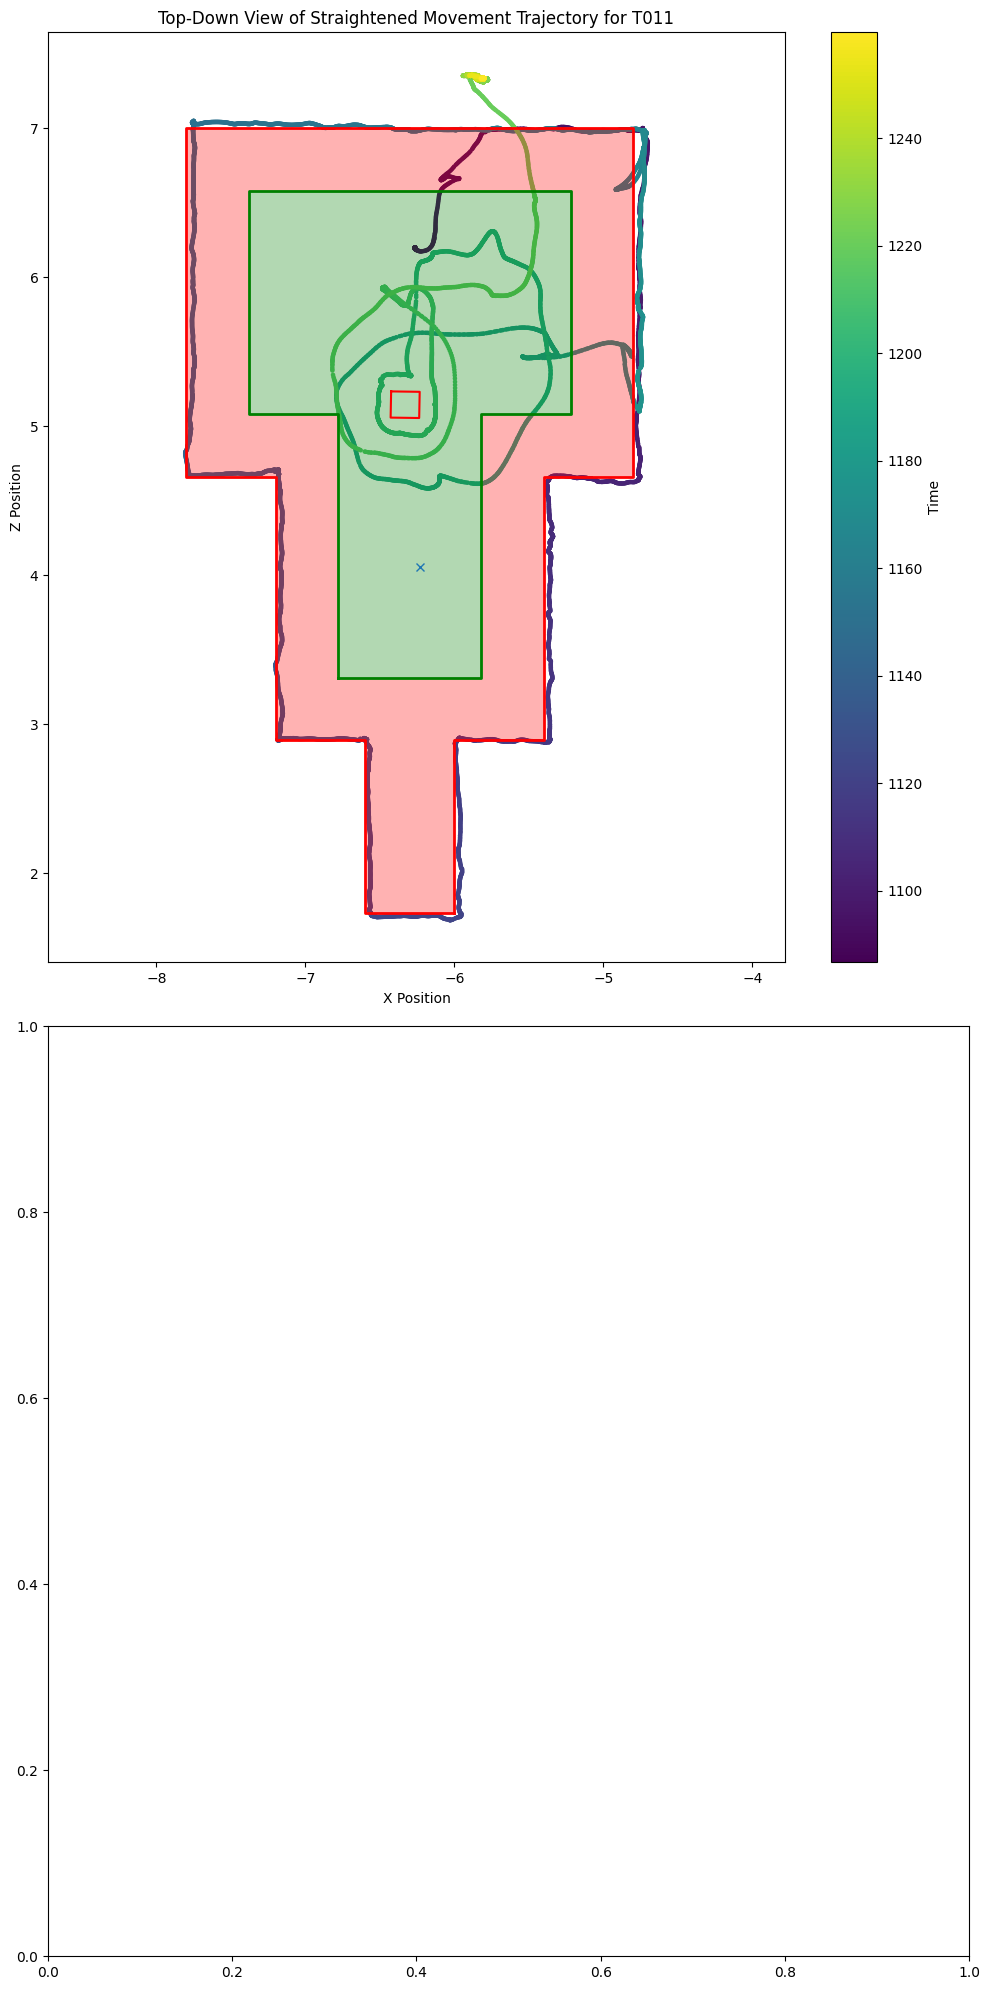